In [1]:
# GPU Code
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"



# import libraries

# PyTorch
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn

import albumentations as A
import torch.optim as optim



# Image processing
from PIL import Image, ImageDraw, ExifTags, ImageColor, ImageFont


# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torch.utils.data import DataLoader
# Data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# xml processing

import xml.etree.ElementTree as ET
from torchvision.transforms import functional as F


# File management
import shutil


# Other
import time
import random

import warnings
warnings.filterwarnings('ignore')



# Path

In [2]:
# Make directory

if not os.path.exists('./data'):
    os.mkdir('./data')

if not os.path.exists('./data/test'):
    os.mkdir('./data/test')
    if not os.path.exists('./data/test/annotations'):
        os.mkdir('./data/test/annotations')
    if not os.path.exists('./data/test/images'):
        os.mkdir('./data/test/images')

if not os.path.exists('./data/train'):
    os.mkdir('./data/train')
    if not os.path.exists('./data/train/annotations'):
        os.mkdir('./data/train/annotations')
    if not os.path.exists('./data/train/images'):
        os.mkdir('./data/train/images')

if not os.path.exists('./data/val'):
    os.mkdir('./data/val')
    if not os.path.exists('./data/val/annotations'):
        os.mkdir('./data/val/annotations')
    if not os.path.exists('./data/val/images'):
        os.mkdir('./data/val/images')
    

In [3]:
# path data 
directory = r"./directory"
annotations = os.path.join(directory, "annotations")
image = os.path.join(directory, "images")



################################################################################
################################################################################
## test data
test_path = os.path.join(r"./data", "test")
annotations_test = os.path.join(test_path, "annotations")
image_test = os.path.join(test_path, "images")

## train data
train_path = os.path.join(r"./data", "train")
annotations_train = os.path.join(train_path, "annotations")
image_train = os.path.join(train_path, "images")
## val data
val_path = os.path.join(r"./data", "val")
annotations_val = os.path.join(val_path, "annotations")
image_val = os.path.join(val_path, "images")


In [4]:


annotations_list = os.listdir(annotations)
images_list = os.listdir(image)

annotations_list.sort()
images_list.sort()


# Split data
# 50 % for train
train_annotations, temp_annotations, train_images, temp_images = train_test_split(
    annotations_list, images_list, test_size=0.5, random_state=42
)
# 25 % for val
# 25 % for test
val_annotations, test_annotations, val_images, test_images = train_test_split(
    temp_annotations, temp_images, test_size=2/5, random_state=42  
)





In [5]:
for file in train_annotations:
    shutil.copyfile(os.path.join(annotations, file), os.path.join(annotations_train, file))
for file in val_annotations:
    shutil.copyfile(os.path.join(annotations, file), os.path.join(annotations_val, file))
for file in test_annotations:
    shutil.copyfile(os.path.join(annotations, file), os.path.join(annotations_test, file))
for file in train_images:
    shutil.copyfile(os.path.join(image, file), os.path.join(image_train, file))
for file in val_images:
    shutil.copyfile(os.path.join(image, file), os.path.join(image_val, file))
for file in test_images:
    shutil.copyfile(os.path.join(image, file), os.path.join(image_test, file))
    

In [ ]:
# process data


def parse_voc_annotation(annotation):
    tree = ET.parse(annotation)
    root = tree.getroot()

    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)

    boxes = []
    labels = []
    area = []
    iscrowd = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        
        labels.append(1)  

        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

        area.append((xmax - xmin) * (ymax - ymin))

        iscrowd.append(0)

    return {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64),
        "area": torch.tensor(area, dtype=torch.float32),
        "iscrowd": torch.tensor(iscrowd, dtype=torch.int64),
        "image_id": torch.tensor([int(root.find("filename").text.split('.')[0].replace("maksssksksss", ""))])
    }
    
    



In [55]:

image_list_train_tensor = []
target_list_train = []

for file in os.listdir(annotations_train):
    annotation = os.path.join(annotations_train, file)
    target = parse_voc_annotation(annotation)
    image = Image.open(os.path.join(image_train, file.split('.')[0]+'.png')).convert("RGB")
    image_tensor = F.to_tensor(image)
    image_list_train_tensor.append(image_tensor)
    target_list_train.append(target)
    
image_list_val_tensor = []
target_list_val = []

for file in os.listdir(annotations_val):
    annotation = os.path.join(annotations_val, file)
    target = parse_voc_annotation(annotation)
    image = Image.open(os.path.join(image_val, file.split('.')[0]+'.png')).convert("RGB")
    image_tensor = F.to_tensor(image)
    image_list_val_tensor.append(image_tensor)
    target_list_val.append(target)
    
image_list_test_tensor = []
target_list_test = []

for file in os.listdir(annotations_test):
    annotation = os.path.join(annotations_test, file)
    target = parse_voc_annotation(annotation)
    image = Image.open(os.path.join(image_test, file.split('.')[0]+'.png')).convert("RGB")
    image_tensor = F.to_tensor(image)
    image_list_test_tensor.append(image_tensor)
    target_list_test.append(target)

In [57]:
# divide 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def build_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True, min_size=400, max_size=700)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

model = build_model(4)
model.to(device)
model.train()



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(400,), max_size=700, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(i

In [58]:
# optimizer and scheduler


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)




In [59]:

def train(model, optimizer, scheduler, train_loader, val_loader, num_epochs):
    """Train the Faster R-CNN model with the given dataset and optimizer.

    Args:
        model (_type_): Faster R-CNN model.
        optimizer (_type_): Optimizer for model parameters.
        scheduler (_type_): Learning rate scheduler.
        train_loader (_type_): DataLoader for training data.
        val_loader (_type_): DataLoader for validation data.
        num_epochs (_type_): Number of epochs to train.

    Returns:
        model: Trained model.
        loss_list: List of average losses per epoch.
    """
    loss_list = []
    for epoch in range(num_epochs):
        print(f'Starting epoch {epoch + 1}/{num_epochs}')
        model.train()
        loss_sub_list = []
        start = time.time()

        for iteration, (images, targets) in enumerate(train_loader, start=1):
            images = [image.to(device) for image in images]
            targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

            # Forward pass: Compute loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            loss_sub_list.append(loss_value)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if iteration % 100 == 0:
                print(f"Iteration {iteration} Loss: {loss_value}")

        epoch_loss = sum(loss_sub_list) / len(loss_sub_list)
        print(f"Epoch {epoch + 1} Loss: {epoch_loss}")
        loss_list.append(epoch_loss)

        scheduler.step()

        # Optionally, validate the model after each epoch
        # evaluate_model(model, val_loader)

        # Print time taken for the epoch
        end = time.time()
        print(f"Time for epoch {epoch + 1}: {end - start:.2f} seconds")

    return model, loss_list

In [60]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        return image, target


In [61]:
def collate_fn(batch):
    return tuple(zip(*batch))  


In [ ]:


train_dataset = CustomDataset(image_list_train_tensor, target_list_train)
val_dataset = CustomDataset(image_list_val_tensor, target_list_val)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

model, loss_list = train(model, optimizer, lr_scheduler, train_loader, val_loader, num_epochs=10)


Starting epoch 1/10


KeyboardInterrupt: 

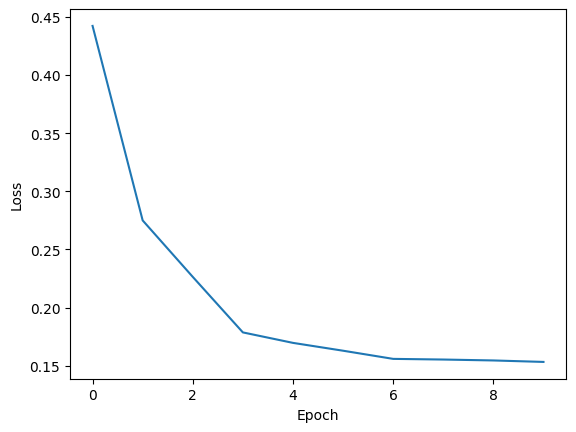

In [32]:
# save model
torch.save(model.state_dict(), 'faster_rcnn_model.pth')
# save loss
torch.save(loss_list, 'loss_list.pth')


# visualize loss
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [66]:
save_path = r"D:\Python\RCNN\result_predict"
image_path_ = r"D:\Python\RCNN\data\test\images"

model.load_state_dict(torch.load(r"D:\Python\RCNN\faster_rcnn_model.pth"))
model.eval()

def predict(image_path, model):
    image = Image.open(image_path).convert("RGB")
    
    image_tensor = F.to_tensor(image)
    
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad(): 
        prediction = model([image_tensor]) 
    
    return prediction, image



threshold = 0.5

for image_path in os.listdir(image_path_):
    image_path = os.path.join(image_path_, image_path)
    prediction, image = predict(image_path, model)

    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']  

    for box, label, score in zip(boxes, labels, scores):
        if score < threshold:
            continue
        print(f"Label: {label}, Box: {box}, Score: {score}")

    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)

    for box, label, score in zip(boxes, labels, scores):
        if score < threshold:
            continue
        x1, y1, x2, y2 = box
        draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=4)
        draw.text((x1, y1 - 10), f"{label.item()}: {score:.2f}", fill="red")

    image_copy.save(f"{save_path}\{os.path.basename(image_path)[:-4]}.png")


Label: 1, Box: tensor([184.8577,  99.9862, 227.5989, 146.0014], device='cuda:0'), Score: 0.9977600574493408
Label: 1, Box: tensor([324.0905,  91.6909, 362.8186, 144.1993], device='cuda:0'), Score: 0.9961848855018616
Label: 1, Box: tensor([ 75.7472, 102.2827, 110.1493, 138.2194], device='cuda:0'), Score: 0.9903379678726196
Label: 1, Box: tensor([ 97.1541, 268.7362, 193.4940, 380.0746], device='cuda:0'), Score: 0.998760461807251
Label: 1, Box: tensor([189.9766,  31.2827, 242.9875,  89.1467], device='cuda:0'), Score: 0.9985846281051636
Label: 1, Box: tensor([123.9382,  86.6666, 163.0775, 125.9505], device='cuda:0'), Score: 0.9968274235725403
Label: 1, Box: tensor([389.4749,  54.6447, 400.0000,  76.4979], device='cuda:0'), Score: 0.9849275350570679
Label: 1, Box: tensor([385.1395, 104.1026, 400.0000, 125.5094], device='cuda:0'), Score: 0.678583025932312
Label: 1, Box: tensor([214.8110,  59.4060, 253.1404,  98.3260], device='cuda:0'), Score: 0.9907435774803162
Label: 1, Box: tensor([117.167